# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch18/ch18_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

--2023-10-12 14:03:41--  https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1629 (1.6K) [text/plain]
Saving to: ‘python_environment_check.py’

python_environment_ 100%[===================>]   1.59K  --.-KB/s    in 0s      

2023-10-12 14:03:41 (22.9 MB/s) - ‘python_environment_check.py’ saved [1629/1629]



권장 패키지 버전을 확인하세요:

In [2]:
from python_environment_check import check_packages


d = {
    'torch': '1.8.0',
    'networkx': '2.6.2',
    'numpy': '1.21.2',
}

check_packages(d)

[OK] Your Python version is 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
[OK] torch 2.0.1+cu118
[OK] networkx 3.1
[OK] numpy 1.23.5


# 18장 - 그래프 구조 데이터의 의존성 감지를 위한 그래프 신경망 (Part 1/2)

- 그래프 데이터 소개
  - 비유향 그래프
  - 유향 그래프
  - 레이블 그래프
  - 분자를 그래프로 표현하기
- 그래프 합성곱 이해
  - 그래프 합성곱의 사용 동기
  - 기본 그래프 합성곱 구현
- 파이토치에서 GNN을 밑바닥부터 구현하기
  - NodeNetwork 모델 정의하기
  - NodeNetwork의 그래프 합성곱 층 만들기
  - 다양한 그래프 크기를 처리하기 위해 전역 풀링 층 추가하기
  - 데이터로더 준비
  - NodeNetwork를 사용하여 예측하기

In [3]:
from IPython.display import Image
%matplotlib inline

## 그래프 데이터 소개

In [4]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_01.png', width=500)

### 비유향 그래프

In [5]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_02.png', width=500)

### 유향 그래프

In [6]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_03.png', width=300)

### 레이블 그래프

### 분자를 그래프로 표현하기

In [7]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_04.png', width=500)

## 그래프 합성곱 이해

### 그래프 합성곱의 사용 동기

In [8]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_05.png', width=500)

### 기본 그래프 합성곱 구현

In [9]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_06.png', width=500)

In [10]:
import networkx as nx
import numpy as np

In [11]:
G = nx.Graph()

# 그래프를 그리기 위해 색을 16진수 코드로 나타냅니다.
blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"

G.add_nodes_from([(1, {"color": blue}),
                  (2, {"color": orange}),
                  (3, {"color": blue}),
                  (4, {"color": green})])

G.add_edges_from([(1, 2),(2, 3),(1, 3),(3, 4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


In [12]:
def build_graph_color_label_representation(G,mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in
                             nx.get_node_attributes(G, 'color').values()])
    one_hot_encoding = np.zeros((one_hot_idxs.size,len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size),one_hot_idxs] = 1
    return one_hot_encoding

X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})
print(X)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


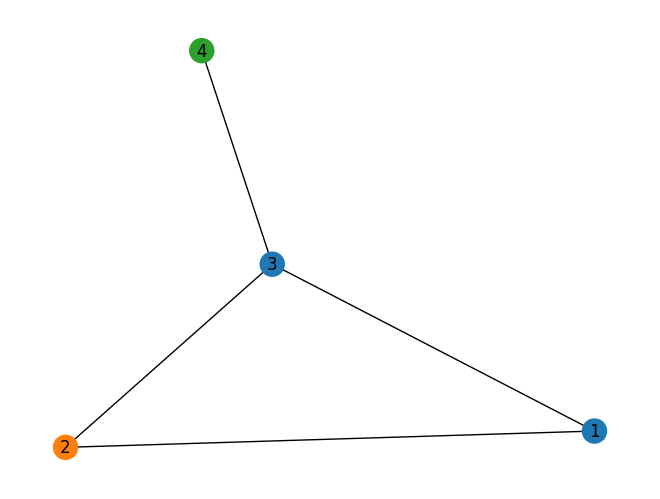

In [13]:
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw(G, with_labels=True, node_color=color_map)

In [14]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_07.png', width=800)

In [15]:
f_in, f_out = X.shape[1], 6
W_1 = np.random.rand(f_in, f_out)
W_2 = np.random.rand(f_in, f_out)
h = np.dot(X,W_1) + np.dot(np.dot(A, X), W_2)

In [16]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_08.png', width=500)

## 파이토치에서 GNN을 밑바닥부터 구현하기

### NodeNetwork 모델 정의하기

In [17]:
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import numpy as np
import torch.nn.functional as F

In [18]:
class NodeNetwork(torch.nn.Module):

    def __init__(self, input_features):
        super().__init__()

        self.conv_1 = BasicGraphConvolutionLayer(input_features, 32)
        self.conv_2 = BasicGraphConvolutionLayer(32, 32)
        self.fc_1 = torch.nn.Linear(32, 16)
        self.out_layer = torch.nn.Linear(16, 2)

    def forward(self, X, A,batch_mat):
        x = self.conv_1(X, A).clamp(0)
        x = self.conv_2(x, A).clamp(0)
        output = global_sum_pool(x, batch_mat)
        output = self.fc_1(output)
        output = self.out_layer(output)
        return F.softmax(output, dim=1)

In [19]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_09.png', width=700)

### NodeNetwork의 그래프 합성곱 층 만들기

In [20]:
class BasicGraphConvolutionLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.W2 = Parameter(torch.rand(
             (in_channels, out_channels), dtype=torch.float32))
        self.W1 = Parameter(torch.rand(
             (in_channels, out_channels), dtype=torch.float32))

        self.bias = Parameter(torch.zeros(
                 out_channels, dtype=torch.float32))

    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.W1)
        output = propagated_msgs + root_update + self.bias
        return output

### 다양한 그래프 크기를 처리하기 위해 전역 풀링 층 추가하기

In [21]:
def global_sum_pool(X, batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim=0).unsqueeze(0)
    else:
        return torch.mm(batch_mat, X)

In [22]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_10.png', width=600)

In [23]:
def get_batch_tensor(graph_sizes):
    starts = [sum(graph_sizes[:idx]) for idx in range(len(graph_sizes))]
    stops = [starts[idx]+graph_sizes[idx] for idx in range(len(graph_sizes))]
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)
    batch_mat = torch.zeros([batch_size, tot_len]).float()
    for idx, starts_and_stops in enumerate(zip(starts, stops)):
        start = starts_and_stops[0]
        stop = starts_and_stops[1]
        batch_mat[idx, start:stop] = 1
    return batch_mat

In [24]:
def collate_graphs(batch):
    adj_mats = [graph['A'] for graph in batch]
    sizes = [A.size(0) for A in adj_mats]
    tot_size = sum(sizes)
    # 배치 행렬을 만듭니다.
    batch_mat = get_batch_tensor(sizes)
    # 특성 행렬을 연결합니다.
    feat_mats = torch.cat([graph['X'] for graph in batch],dim=0)
    # 레이블을 연결합니다.
    labels = torch.cat([graph['y'] for graph in batch], dim=0)
    # 인접 행렬을 결합합니다.
    batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum:accum+g_size, accum:accum+g_size] = adj
        accum = accum + g_size
    repr_and_label = {
            'A': batch_adj,
            'X': feat_mats,
            'y': labels,
            'batch' : batch_mat}

    return repr_and_label

### DataLoader 준비

In [25]:
def get_graph_dict(G, mapping_dict):
    # 그래프 G의 딕셔너리 표현을 만드는 함수
    A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()
    # build_graph_color_label_representation()는
    # 첫 번째 예제 그래프와 함께 소개했습니다.
    X = torch.from_numpy(build_graph_color_label_representation(G,mapping_dict)).float()
    # 이 예제는 특정 작업이 없습니다.
    y = torch.tensor([[1, 0]]).float()
    return {'A': A, 'X': X, 'y': y, 'batch': None}

# 하나의 데이터셋으로 다룰 네 개의 그래프를 만듭니다.
blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"
mapping_dict = {green: 0, blue: 1, orange: 2}

G1 = nx.Graph()
G1.add_nodes_from([(1, {"color": blue}),
                   (2, {"color": orange}),
                   (3, {"color": blue}),
                   (4, {"color": green})])
G1.add_edges_from([(1, 2), (2, 3),(1, 3), (3, 4)])
G2 = nx.Graph()
G2.add_nodes_from([(1, {"color": green}),
                   (2, {"color": green}),
                   (3, {"color": orange}),
                   (4, {"color": orange}),
                   (5,{"color": blue})])
G2.add_edges_from([(2, 3),(3, 4),(3, 1),(5, 1)])
G3 = nx.Graph()
G3.add_nodes_from([(1, {"color": orange}),
                   (2, {"color": orange}),
                   (3, {"color": green}),
                   (4, {"color": green}),
                   (5, {"color": blue}),
                   (6, {"color":orange})])
G3.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1), (2, 5), (6, 1)])
G4 = nx.Graph()
G4.add_nodes_from([(1, {"color": blue}), (2, {"color": blue}), (3, {"color": green})])
G4.add_edges_from([(1, 2), (2, 3)])
graph_list = [get_graph_dict(graph,mapping_dict) for graph in [G1, G2, G3, G4]]

In [26]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_11.png', width=600)

In [27]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class ExampleDataset(Dataset):

    # 그래프 리스트를 활용하는 간단한 파이토치 데이터셋
    def __init__(self, graph_list):
        self.graphs = graph_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self,idx):
        mol_rep = self.graphs[idx]
        return mol_rep

In [28]:
dset = ExampleDataset(graph_list)
# 사용자 정의 콜레이트 함수 사용 방법
loader = DataLoader(dset, batch_size=2, shuffle=False, collate_fn=collate_graphs)

### NodeNetwork를 사용하여 예측하기

In [29]:
torch.manual_seed(123)
node_features = 3
net = NodeNetwork(node_features)

In [30]:
batch_results = []

for b in loader:
    batch_results.append(net(b['X'], b['A'], b['batch']).detach())

G1_rep = dset[1]
G1_single = net(G1_rep['X'], G1_rep['A'], G1_rep['batch']).detach()

G1_batch = batch_results[0][1]
torch.all(torch.isclose(G1_single, G1_batch))

tensor(True)